In [207]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm, tqdm_notebook, trange
from scipy.optimize import fmin
from pylab import rcParams
from IPython.display import clear_output
import copy

from sklearn.metrics import f1_score, roc_auc_score, log_loss, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from eli5.permutation_importance import get_score_importances as importances
import lightgbm as lgb

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from torch.autograd import Variable

In [208]:
# Imports for better visualization
from matplotlib import rcParams
#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (10, 4)
rcParams['figure.dpi'] = 150
#rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 8
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'

In [209]:
pd.set_option('max_columns',100)
pd.set_option('max_rows',100)

In [210]:
train = pd.read_csv('Final_train_fe.csv')
test = pd.read_csv('Final_test_fe.csv')
train.shape, test.shape

((803, 34), (203, 34))

In [211]:
train.head()

,ID,Default,Checking_amount,Term,Credit_score,Gender,Marital_status,Car_loan,Personal_loan,Home_loan,Education_loan,Emp_status,Amount,Saving_amount,Emp_duration,Age,No_of_credit_acc,bal_status,total_bal,loan_to_tot_bal,loan_to_saving,loan_to_score,total_loan,credit_score_bins,age_bins,term_diff_emp_duration,loan_bal_diff_tot_bal,tot_bal_diff_loan_bal,Age_count,Age_tot_loan,Age_mean_loan,Age_tot_saving_bal,Age_tot_mean_bal,Age_flag_mean
0,101,0.0,988.0,15.0,796.0,0,0,1,0,0,0,0,1536.0,3455.0,12.0,38.0,1.0,0,4443.0,0.345712,0.444573,1.929648,1,0.293194,0.000000,3.0,-2907.0,2907.0,25,29013.0,1160.520000,84550.0,3382.000000,0.000000
1,102,0.0,458.0,15.0,813.0,0,0,1,0,0,0,0,947.0,3600.0,25.0,36.0,1.0,0,4058.0,0.233366,0.263056,1.164822,1,0.185000,0.000000,-10.0,-3111.0,3111.0,61,74891.0,1227.721311,200035.0,3279.262295,0.000000
2,103,0.0,158.0,14.0,756.0,0,0,0,1,0,0,0,1678.0,3093.0,43.0,34.0,1.0,0,3251.0,0.516149,0.542515,2.219577,1,0.293194,0.266925,-29.0,-1573.0,1573.0,75,89144.0,1188.586667,247193.0,3295.906667,0.072727
3,104,1.0,300.0,25.0,737.0,0,0,0,0,0,1,0,1804.0,2449.0,0.0,29.0,1.0,0,2749.0,0.656239,0.736627,2.447761,1,0.293194,0.266925,25.0,-945.0,945.0,78,97245.0,1246.730769,238899.0,3062.807692,0.539683
4,105,1.0,63.0,24.0,662.0,0,0,0,0,0,1,1,1184.0,2867.0,4.0,30.0,1.0,0,2930.0,0.404096,0.412975,1.788520,1,0.293194,0.266925,20.0,-1746.0,1746.0,89,108573.0,1219.921348,281221.0,3159.786517,0.267606


In [212]:
train_X = train.drop(['ID', 'Default'], axis=1)
test_X = test.drop(['ID', 'Default'], axis=1)
train_X.shape, test_X.shape

((803, 32), (203, 32))

In [213]:
drop_cols = ['ID', 'Default']
X = train.drop(drop_cols, axis=1)
y = train['Default']
Xtest = test.drop(drop_cols, axis=1)
X.shape, Xtest.shape

((803, 32), (203, 32))

In [214]:
class LGBWrapper(object):
    def __init__(self, params=None):
        self.params = params

    def fit(self, X, y):
        _X = lgb.Dataset(X, label=y)
        self.model = lgb.train(self.params, _X)

    def predict(self, X):
        return self.model.predict(X)

In [215]:
def get_oof_pred(model, X, y, folds):   
    cvpred = np.zeros(X.shape[0])
    for tr, te in tqdm_notebook(folds.split(X, y)):
        X_tr, X_te = X.loc[tr], X.loc[te]
        y_tr, y_te = y[tr], y[te]
        model.fit(X_tr, y_tr)
        cvpred[te] = model.predict(X_te)
    return cvpred
# just without tqdm
def get_oof_pred2(model, X, y, folds):   
    cvpred = np.zeros(X.shape[0])
    for tr, te in folds.split(X, y):
        X_tr, X_te = X.loc[tr], X.loc[te]
        y_tr, y_te = y[tr], y[te]
        model.fit(X_tr, y_tr)
        cvpred[te] = model.predict(X_te)
    return cvpred

In [216]:
def get_oof(model, X, y, test, folds, metric, permute=False):
    
    def score(X, y):
        y_pred = model.predict(X)
        return metric(y, y_pred)
    
    cvpred = np.zeros(X.shape[0])
    pred = np.zeros(test.shape[0])
    global_imp = np.zeros(X.shape[1])
    for tr, te in tqdm_notebook(folds.split(X, y)):
        X_tr, X_te = X.loc[tr], X.loc[te]
        y_tr, y_te = y[tr], y[te]
        model.fit(X_tr, y_tr)
        cvpred[te] = model.predict(X_te)
        pred += model.predict(test)
        if permute is True:
            base_score, local_imp = importances(score, X_te.values, y_te, n_iter=5, random_state=0)
            global_imp += np.mean(local_imp, axis=0)
    global_imp /= folds.get_n_splits() * (-1)
    pred /= folds.get_n_splits()
    return cvpred, pred, global_imp

#compute permutation importance and run 'BACKWARD'
class FeatureSelector(object):
    def __init__(self, model, folds, metric):
        self.model = model
        self.folds = folds
        self.metric = metric
    
    def fit(self, X, y, test):
        cvpred, pred, importance = get_oof(self.model, X, y, test, self.folds, self.metric, permute=True)
        base_score = self.metric(y, cvpred)
        best_score = base_score
        self.initial_importance = sorted(list(zip(importance, X.columns)), key=lambda x: x[0])
        with open('WNS_selector_importance_raw', 'wb') as fp:
            pickle.dump(dict(self.initial_importance), fp)
        to_drop = []
        print('Base score is:', base_score, '\n')
        for f in tqdm_notebook(self.initial_importance):
            to_drop.append(f[1])
            _X = X.drop(to_drop, axis=1)
            _test = test.drop(to_drop, axis=1)
            cvpred, pred, imp = get_oof(self.model, _X, y, _test, self.folds, self.metric)
            if self.metric(y, cvpred) > best_score:
                to_drop.pop()
            else:
                print('Feature ' + str(f[1]) + ' has been dropped >>')
                print('Score: ' + str(best_score) + ' -> ' + str(self.metric(y, cvpred)))
                best_score = self.metric(y, cvpred)
                print()        
        print('Final score: ', best_score)
        self.weak_features = to_drop
        self.strong_features = list(set(X.columns) - set(to_drop))
        self.oof_train = cvpred
        self.oof_test = pred
        self.final_importance = imp
        return self

In [217]:
def get_oof2(model, X, y, test, folds, metric, permute=False):
    
    def score(X, y):
        y_pred = model.predict(X)
        
        def minus_f_score(cutoff):
            if (cutoff < 0) or (cutoff > 1):
                return np.inf
            else:
                return - 1* f1_score(y, 1 * (y_pred > cutoff))
            
        cutoff_null = [0]
        cut_f_min = fmin(minus_f_score, cutoff_null, disp=False)
        cut = cut_f_min[0]
            
        return f1_score(y, 1 * (y_pred > cut))
    
    cvpred = np.zeros(X.shape[0])
    pred = np.zeros(test.shape[0])
    global_imp = np.zeros(X.shape[1])
    for tr, te in folds.split(X, y):
        X_tr, X_te = X.loc[tr], X.loc[te]
        y_tr, y_te = y[tr], y[te]
        model.fit(X_tr, y_tr)
        cvpred[te] = model.predict(X_te)
        pred += model.predict(test)
        if permute is True:
            base_score, local_imp = importances(score, X_te.values, y_te, n_iter=5, random_state=0)
            global_imp += np.mean(local_imp, axis=0)
    global_imp /= folds.get_n_splits()
    pred /= folds.get_n_splits()
    return cvpred, pred, global_imp
# Same, but score is optimal f1-score for each prediction
class FeatureSelector2(object):
    def __init__(self, model, folds, metric):
        self.model = model
        self.folds = folds
        self.metric = metric
        
    
    def fit(self, X, y, test):
        def score2(y, y_pred):
        
            def minus_f_score(cutoff):
                if (cutoff < 0) or (cutoff > 1):
                    return np.inf
                else:
                    return - 1* f1_score(y, 1 * (y_pred > cutoff))

            cutoff_null = [0]
            cut_f_min = fmin(minus_f_score, cutoff_null, disp=False)
            cut = cut_f_min[0]

            return f1_score(y, 1 * (y_pred > cut))
            
        cvpred, pred, importance = get_oof2(self.model, X, y, test, self.folds, self.metric, permute=True)
        base_score = score2(y, cvpred)
        best_score = base_score
        self.initial_importance = sorted(list(zip(importance, X.columns)), key=lambda x: x[0])
        to_drop = []
        print('Base score is:', base_score, '\n')
        for f in tqdm_notebook(self.initial_importance):
            to_drop.append(f[1])
            _X = X.drop(to_drop, axis=1)
            _test = test.drop(to_drop, axis=1)
            cvpred, pred, imp = get_oof2(self.model, _X, y, _test, self.folds, self.metric)
            if score2(y, cvpred) <= best_score:
                to_drop.pop()
            else:
                print('Feature ' + str(f[1]) + ' has been dropped >>')
                print('Score: ' + str(best_score) + ' -> ' + str(score2(y, cvpred)))
                best_score = score2(y, cvpred)
                print()        
        print('Final score: ', best_score)
        self.weak_features = to_drop
        self.strong_features = list(set(X.columns) - set(to_drop))
        self.oof_train = cvpred
        self.oof_test = pred
        self.final_importance = imp
        return self

In [218]:
def plot_history_a( M_train_history):
    plt.style.use('ggplot')
    plt.figure(figsize=[6,6])
    
    plt.title('MSE Loss')
    plt.plot(M_train_history, label='MSE', zorder=1, c='lightseagreen')
    plt.xlabel('Iteration')
    
    plt.legend   
    plt.show()

In [219]:
def iterate_minibatches_a(inputs,  batchsize, shuffle=False):             
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [220]:
data = pd.concat([train_X, test_X]).reset_index(drop=True)
data.shape

(1006, 32)

In [221]:
scaler = MinMaxScaler()
scaler.fit(data)
X_train = scaler.transform(data)

In [222]:
class Autoencoder(nn.Module):
    def __init__(self):
        
        super(Autoencoder, self).__init__()    
        self.fc1 = nn.Linear(int(X_train.shape[1]), int(X_train.shape[1]/2))
        self.fc2 = nn.Linear(int(X_train.shape[1]/2), int(X_train.shape[1]/2))
        self.fc3 = nn.Linear(int(X_train.shape[1]/2), int(X_train.shape[1]))       
        
    def forward(self, x1):
        inputs = x1 
        x = F.leaky_relu(self.fc1(inputs))
        x = F.leaky_relu(self.fc2(x))
        output = F.sigmoid(self.fc3(x))
        return output
        
    def get_error_mse(self, x):
    
        X_mb = Variable(torch.from_numpy(x)).type(torch.FloatTensor).cuda()        
        auto = self.forward(X_mb)
        output = torch.mean((X_mb - auto)**2, dim=1)
        
        return output.data.cpu().numpy()
    
    def get_error_mae(self, x):
    
        X_mb = Variable(torch.from_numpy(x)).type(torch.FloatTensor).cuda()        
        auto = self.forward(X_mb)
        output = torch.mean(torch.abs(X_mb - auto), dim=1)
        
        return output.data.cpu().numpy()

In [223]:
def train_a(model, opt, batchsize=200):
    MSE_log =  []
    for x_batch in iterate_minibatches_a(X_train, batchsize=batchsize, shuffle=True):
        X_mb = Variable(torch.from_numpy(x_batch)).type(torch.FloatTensor).cuda()
        A_solver = opt            
        A_solver.zero_grad()
        output = model(X_mb)
        MSE_train_loss = torch.mean(( X_mb - output)**2)
        MSE_train_loss.backward()
        
        A_solver.step()
        MSE_loss = MSE_train_loss.cpu().data.numpy()
        MSE_log.append(MSE_loss)
        
    return MSE_log

Epoch: 1, MSE loss: 0.02021746151149273


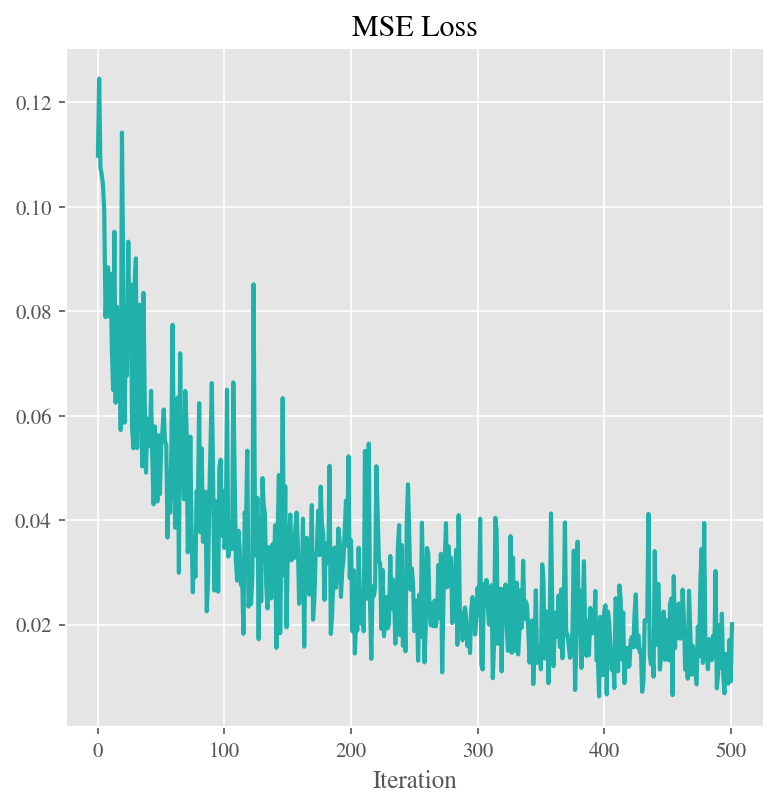

In [224]:
torch.cuda.manual_seed(60)
torch.manual_seed(60)

MSE_loss_log = []

batchsize = 4
lr = 0.02


Autoencoder_model = Autoencoder().cuda()

opt = torch.optim.Adam(Autoencoder_model.parameters(), lr=lr)

for epoch in range(2):
    steps = X_train.shape[0]/batchsize

    MSE_loss = train_a(Autoencoder_model, opt, batchsize=batchsize)

    MSE_loss_log.extend(MSE_loss) 
    clear_output()
    print('Epoch: {e}, MSE loss: {M1}'.format(e=epoch, M1=np.mean(MSE_loss)))
    
    plot_history_a( MSE_loss_log)

In [225]:

data['reconstruction_error_mse'] = Autoencoder_model.eval().get_error_mse(X_train)
data['reconstruction_error_mae'] = Autoencoder_model.eval().get_error_mae(X_train)

C:\Users\shankar\Anaconda3\envs\tf\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [226]:
data.to_csv('data_feat_with_re.csv', index=False)

In [227]:
data.shape

(1006, 34)

In [228]:
data.head()

,Checking_amount,Term,Credit_score,Gender,Marital_status,Car_loan,Personal_loan,Home_loan,Education_loan,Emp_status,Amount,Saving_amount,Emp_duration,Age,No_of_credit_acc,bal_status,total_bal,loan_to_tot_bal,loan_to_saving,loan_to_score,total_loan,credit_score_bins,age_bins,term_diff_emp_duration,loan_bal_diff_tot_bal,tot_bal_diff_loan_bal,Age_count,Age_tot_loan,Age_mean_loan,Age_tot_saving_bal,Age_tot_mean_bal,Age_flag_mean,reconstruction_error_mse,reconstruction_error_mae
0,988.0,15.0,796.0,0,0,1,0,0,0,0,1536.0,3455.0,12.0,38.0,1.0,0,4443.0,0.345712,0.444573,1.929648,1,0.293194,0.000000,3.0,-2907.0,2907.0,25,29013.0,1160.520000,84550.0,3382.000000,0.000000,0.029709,0.122530
1,458.0,15.0,813.0,0,0,1,0,0,0,0,947.0,3600.0,25.0,36.0,1.0,0,4058.0,0.233366,0.263056,1.164822,1,0.185000,0.000000,-10.0,-3111.0,3111.0,61,74891.0,1227.721311,200035.0,3279.262295,0.000000,0.008098,0.069354
2,158.0,14.0,756.0,0,0,0,1,0,0,0,1678.0,3093.0,43.0,34.0,1.0,0,3251.0,0.516149,0.542515,2.219577,1,0.293194,0.266925,-29.0,-1573.0,1573.0,75,89144.0,1188.586667,247193.0,3295.906667,0.072727,0.002752,0.033598
3,300.0,25.0,737.0,0,0,0,0,0,1,0,1804.0,2449.0,0.0,29.0,1.0,0,2749.0,0.656239,0.736627,2.447761,1,0.293194,0.266925,25.0,-945.0,945.0,78,97245.0,1246.730769,238899.0,3062.807692,0.539683,0.010344,0.072342
4,63.0,24.0,662.0,0,0,0,0,0,1,1,1184.0,2867.0,4.0,30.0,1.0,0,2930.0,0.404096,0.412975,1.788520,1,0.293194,0.266925,20.0,-1746.0,1746.0,89,108573.0,1219.921348,281221.0,3159.786517,0.267606,0.026962,0.119348


In [229]:
train_df = data[0:train.shape[0]]
test_df = data[train.shape[0]:].reset_index(drop=True)
train_df.shape, test_df.shape

((803, 34), (203, 34))

In [230]:
folds = KFold(n_splits=3, shuffle=True, random_state=0)

In [231]:

imp_auc = []
for col in tqdm_notebook(train_df.columns):
    imp_auc.append([col , 2*np.abs(roc_auc_score(y, train_df[col].replace([np.inf, -np.inf], [np.NaN, np.NaN]).fillna(-1)))-1])

C:\Users\shankar\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [232]:
df = pd.DataFrame(imp_auc, columns=['Feature', 'Gini'])

In [233]:
df[df.Gini > 0.30 ].sort_values('Gini').iloc[-10:]

,Feature,Gini
19,loan_to_score,0.351004
18,loan_to_saving,0.389294
1,Term,0.414512
17,loan_to_tot_bal,0.515568
22,age_bins,0.591399
28,Age_mean_loan,0.636635
24,loan_bal_diff_tot_bal,0.733870
31,Age_flag_mean,0.848921


In [234]:
feat_gini = df[df.Gini > 0.3 ].sort_values('Gini').Feature

In [235]:
feat_gini

19            loan_to_score
18           loan_to_saving
1                      Term
17          loan_to_tot_bal
22                 age_bins
28            Age_mean_loan
24    loan_bal_diff_tot_bal
31            Age_flag_mean
Name: Feature, dtype: object

In [236]:
from lightgbm.sklearn import LGBMClassifier
import lightgbm as lgb

In [237]:
params2 = {'app': 'binary',
          'metric': 'binary_logloss',
          'n_jobs': -1
           }

cv_lbg = lgb.cv(nfold=2, shuffle=True,
                metrics='log_loss', params=params2, seed=0, train_set=lgb.Dataset(train, label=y))
m = lgb.LGBMClassifier()
m.fit(train_df, y)
imp_lgb = m.feature_importances_

In [238]:
imp_lgb

array([238, 104, 371,   6,  20,  18,  23,  12,  31,  17,  92, 162,  99,
       231,  38,   0, 371,  92,  82, 114,   0,   1,  16,  69, 155,  42,
        33,   9,  46,  13,  33,  79, 176, 146])

In [239]:
df2 = pd.DataFrame(np.array([train_df.columns, imp_lgb]).T, columns=['Feature', 'imp']).sort_values('imp')

In [240]:
df2.tail()

,Feature,imp
32,reconstruction_error_mse,176
13,Age,231
0,Checking_amount,238
2,Credit_score,371
16,total_bal,371


In [241]:
imp_dict = dict(np.array([imp_lgb + np.random.uniform(0,0.1, imp_lgb.shape), train_df.columns]).T)
ar_imp = np.array(list(imp_dict.keys()))

In [242]:
# 'FORWARD'
feat = []
for i in tqdm(list(reversed([imp_dict.get(g) for g in np.sort(ar_imp)]))):
    feat.append(i)
    if len(feat)==5:
        model = LGBWrapper(params2)
        oof_pred = get_oof_pred2(model, train_df[feat], y, folds)
        base_score = log_loss(y, oof_pred)
        print('Base score: {bs}'.format(bs = base_score))
    if len(feat)>5:
        model = LGBWrapper(params2)
        oof_pred = get_oof_pred2(model, train_df[feat], y, folds)
        if log_loss(y, oof_pred) >= base_score:
            feat.pop()
        else:
            base_score = log_loss(y, oof_pred)
            print('feat {i} was added. Base score: {bs}'.format(i=i, bs = base_score))

 15%|████████████▏                                                                      | 5/34 [00:00<00:03,  8.72it/s]

Base score: 0.20581959360128665


 21%|█████████████████                                                                  | 7/34 [00:01<00:10,  2.68it/s]

feat loan_bal_diff_tot_bal was added. Base score: 0.2046058021375846


 24%|███████████████████▌                                                               | 8/34 [00:02<00:11,  2.21it/s]

feat reconstruction_error_mae was added. Base score: 0.20111592703750295


 38%|███████████████████████████████▎                                                  | 13/34 [00:05<00:12,  1.62it/s]

feat loan_to_tot_bal was added. Base score: 0.199273180296751


 65%|█████████████████████████████████████████████████████                             | 22/34 [00:11<00:07,  1.55it/s]

feat Education_loan was added. Base score: 0.1979950037721774


 68%|███████████████████████████████████████████████████████▍                          | 23/34 [00:11<00:06,  1.59it/s]

feat Personal_loan was added. Base score: 0.19779713900608117


 74%|████████████████████████████████████████████████████████████▎                     | 25/34 [00:13<00:05,  1.60it/s]

feat Car_loan was added. Base score: 0.19135861641648141


 82%|███████████████████████████████████████████████████████████████████▌              | 28/34 [00:15<00:03,  1.60it/s]

feat Age_tot_saving_bal was added. Base score: 0.1890699579091687


 85%|█████████████████████████████████████████████████████████████████████▉            | 29/34 [00:15<00:03,  1.51it/s]

feat Home_loan was added. Base score: 0.18813428925682157


 88%|████████████████████████████████████████████████████████████████████████▎         | 30/34 [00:16<00:02,  1.56it/s]

feat Age_tot_loan was added. Base score: 0.18627863533198752


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:19<00:00,  1.79it/s]


In [243]:

with open('epsilion_selector2_strong_feat', 'wb') as fp:
    pickle.dump(feat, fp)

In [319]:
len(feat)

14

In [320]:
feat

['total_bal',
 'Credit_score',
 'Checking_amount',
 'Age',
 'reconstruction_error_mse',
 'loan_bal_diff_tot_bal',
 'reconstruction_error_mae',
 'loan_to_tot_bal',
 'Education_loan',
 'Personal_loan',
 'Car_loan',
 'Age_tot_saving_bal',
 'Home_loan',
 'Age_tot_loan']

In [245]:
with open('epsilion_selector2_strong_feat', 'rb') as fp:
    selector2_strong_feat = pickle.load(fp)

In [247]:
# data[selector2_strong_feat+['reconstruction_error_mse', 'reconstruction_error_mae']+list(feat_gini)]
select1 = selector2_strong_feat.copy()
for col in feat_gini:
    if col not in select1:
        select1.append(col)
        
for col in ['reconstruction_error_mse', 'reconstruction_error_mae']:
    if col not in select1:
        select1.append(col)

In [250]:
select1

['total_bal',
 'Credit_score',
 'Checking_amount',
 'Age',
 'reconstruction_error_mse',
 'loan_bal_diff_tot_bal',
 'reconstruction_error_mae',
 'loan_to_tot_bal',
 'Education_loan',
 'Personal_loan',
 'Car_loan',
 'Age_tot_saving_bal',
 'Home_loan',
 'Age_tot_loan',
 'loan_to_score',
 'loan_to_saving',
 'Term',
 'age_bins',
 'Age_mean_loan',
 'Age_flag_mean']

In [249]:
len(select1)

20

In [251]:
data_feat = data[select1]
data_feat.shape

(1006, 20)

In [252]:
class TrainTestHelper(object):
    def __init__(self):
        self.ntrain = None

    def combine(self, train, test):
        self.ntrain = train.shape[0]
        if isinstance(train, np.ndarray):
            return np.row_stack((train, test))
        else:
            return train.append(test).reset_index(drop=True)

    def split(self, train_test):
        if self.ntrain is None:
            return None
        if isinstance(train_test, np.ndarray):
            train = train_test[:self.ntrain, :]
            test = train_test[self.ntrain:, :]
        else:
            train = train_test.iloc[:self.ntrain, :].copy().reset_index(drop=True)
            test = train_test.iloc[self.ntrain:, :].copy().reset_index(drop=True)
        return train, test

In [253]:
train_df1 = data_feat[:train_df.shape[0]]
test_df1 = data_feat[train_df.shape[0]:].reset_index(drop=True)
train_df1.shape, test_df1.shape

((803, 20), (203, 20))

In [254]:
params = {'app': 'binary',
          'metric': 'binary_logloss',
          'n_jobs': -1}
model = LGBWrapper(params)

selector2 = FeatureSelector2(model=model, folds=folds, metric=f1_score)
selector2.fit(train_df1, y, train_df1)

Base score is: 0.8862275449101797 



C:\Users\shankar\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Feature loan_to_tot_bal has been dropped >>
Score: 0.8862275449101797 -> 0.8943089430894308

Feature Credit_score has been dropped >>
Score: 0.8943089430894308 -> 0.8961303462321792


Final score:  0.8961303462321792


In [257]:
strong2 = selector2.strong_features

In [258]:
strong2

['loan_to_score',
 'age_bins',
 'loan_bal_diff_tot_bal',
 'total_bal',
 'Term',
 'Age_tot_saving_bal',
 'Home_loan',
 'Age',
 'reconstruction_error_mae',
 'Checking_amount',
 'Age_tot_loan',
 'Age_mean_loan',
 'Car_loan',
 'loan_to_saving',
 'Age_flag_mean',
 'Personal_loan',
 'reconstruction_error_mse',
 'Education_loan']

In [287]:
len(strong2)

18

In [321]:
X = train_df[select1]
Xtest = test_df[select1]
X.shape, Xtest.shape

((803, 20), (203, 20))

In [322]:
X.head()

,total_bal,Credit_score,Checking_amount,Age,reconstruction_error_mse,loan_bal_diff_tot_bal,reconstruction_error_mae,loan_to_tot_bal,Education_loan,Personal_loan,Car_loan,Age_tot_saving_bal,Home_loan,Age_tot_loan,loan_to_score,loan_to_saving,Term,age_bins,Age_mean_loan,Age_flag_mean
0,4443.0,796.0,988.0,38.0,0.029709,-2907.0,0.122530,0.345712,0,0,1,84550.0,0,29013.0,1.929648,0.444573,15.0,0.000000,1160.520000,0.000000
1,4058.0,813.0,458.0,36.0,0.008098,-3111.0,0.069354,0.233366,0,0,1,200035.0,0,74891.0,1.164822,0.263056,15.0,0.000000,1227.721311,0.000000
2,3251.0,756.0,158.0,34.0,0.002752,-1573.0,0.033598,0.516149,0,1,0,247193.0,0,89144.0,2.219577,0.542515,14.0,0.266925,1188.586667,0.072727
3,2749.0,737.0,300.0,29.0,0.010344,-945.0,0.072342,0.656239,1,0,0,238899.0,0,97245.0,2.447761,0.736627,25.0,0.266925,1246.730769,0.539683
4,2930.0,662.0,63.0,30.0,0.026962,-1746.0,0.119348,0.404096,1,0,0,281221.0,0,108573.0,1.788520,0.412975,24.0,0.266925,1219.921348,0.267606


In [323]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score, log_loss

In [332]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((602, 20), (602,), (201, 20), (201,))

In [333]:
result = pd.DataFrame()

In [325]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

err_lgb_ac = []
err_lgb_f1 = []
err_lgb_prec = []
err_lgb_rec = []
err_lgb_auc = []

y_pred_tot_lgb = []
y_pred_tot_lgb_prob = []


fold = KFold(n_splits=5, shuffle=True, random_state=42)
f = 0
for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    m=LGBMClassifier(n_estimators=1000,random_state=1994,learning_rate=0.03,colsample_bytree=0.2,objective='binary',
                     scale_pos_weight=1, bagging_fraction = 0.7265, feature_fraction = 0.5369, lambda_l2=0.05784,
                 min_data_in_leaf= 5, num_leaves=4)

    m.fit(X_train,y_train,eval_set=[(X_test, y_test)],eval_metric='auc', early_stopping_rounds=200,verbose=200)
    
    y_pred = m.predict(X_test)
    y_pred_prob = m.predict_proba(X_test)[:,1]
    
    test_pred = m.predict(Xtest)
    test_pred_proba = m.predict_proba(Xtest)[:,1]
    
    err_ac = accuracy_score(y_test, y_pred)
    err_f1 = f1_score(y_test, y_pred, average='weighted')
    err_prec = precision_score(y_test, y_pred, average='weighted')
    err_rec = recall_score(y_test, y_pred, average='weighted')
    err_auc = roc_auc_score(y_test, y_pred_prob)
    
    f += 1
    print("Fold:", f)
    print("Accuracy:", err_ac)
    print('F1 Score:', err_f1)
    print("Precision Score:", err_prec)
    print("Recall Score:", err_rec)
    print("AUC Score:", err_auc)
    print('\n')
    
    err_lgb_ac.append(err_ac)
    err_lgb_f1.append(err_f1)
    err_lgb_prec.append(err_prec)
    err_lgb_rec.append(err_rec)
    err_lgb_auc.append(err_auc)
    
    y_pred_tot_lgb.append(test_pred)
    y_pred_tot_lgb_prob.append(test_pred_proba)
    

Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.985116	valid_0's binary_logloss: 0.160567
Early stopping, best iteration is:
[168]	valid_0's auc: 0.986154	valid_0's binary_logloss: 0.163248
Fold: 1
Accuracy: 0.9316770186335404
F1 Score: 0.9318300442195787
Precision Score: 0.9320616217252804
Recall Score: 0.9316770186335404
AUC Score: 0.9861543786777431


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.977512	valid_0's binary_logloss: 0.165891
[400]	valid_0's auc: 0.977512	valid_0's binary_logloss: 0.159762
Early stopping, best iteration is:
[334]	valid_0's auc: 0.978983	valid_0's binary_logloss: 0.156399
Fold: 2
Accuracy: 0.9440993788819876
F1 Score: 0.9438504707360075
Precision Score: 0.9436980574447785
Recall Score: 0.9440993788819876
AUC Score: 0.9789827658680118


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.983525	valid_0's binary_logloss: 0.160641
[400]	valid_0's auc:

In [326]:
print(np.mean(err_lgb_ac))
print(np.mean(err_lgb_f1))
print(np.mean(err_lgb_prec))
print(np.mean(err_lgb_rec))
print(np.mean(err_lgb_auc))

0.9365062111801242
0.9361350140179786
0.9369796223699198
0.9365062111801242
0.983541290325106


In [334]:
result['lgbm1'] = np.mean(y_pred_tot_lgb, 0).round().astype(int)
result['lgbm1'].value_counts()

0    145
1     58
Name: lgbm1, dtype: int64

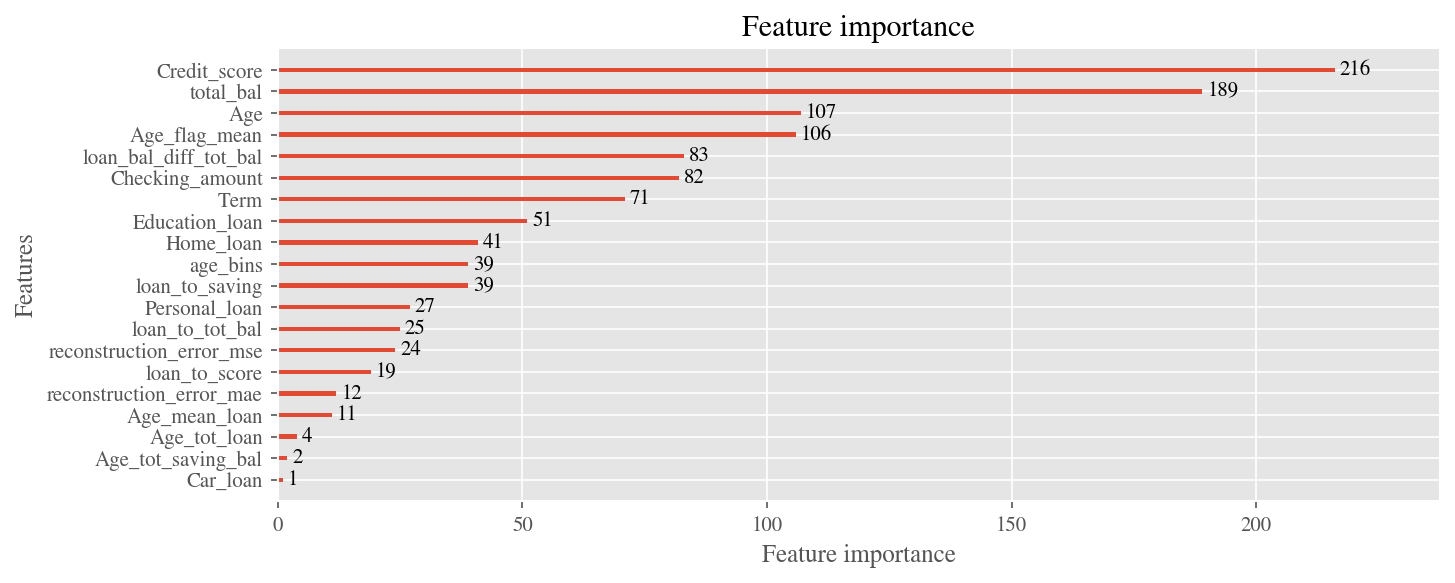

In [335]:
from lightgbm import plot_importance
plot_importance(m, max_num_features=40)
plt.savefig('lgbm_select1_plot.png')

In [336]:
from xgboost import XGBClassifier

err_xgb_ac = []
err_xgb_f1 = []
err_xgb_prec = []
err_xgb_rec = []
err_xgb_auc = []

y_pred_tot_xgb = []
y_pred_tot_xgb_prob = []


fold = KFold(n_splits=5, shuffle=True, random_state=42)
f = 0
for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    m=XGBClassifier(n_estimators=1000,random_state=1994,eval_metric='auc',learning_rate=0.1, bagging_fraction = 0.7265, 
                    feature_fraction = 0.5369, lambda_l2=0.05784,
                 min_data_in_leaf= 5, num_leaves=4)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200,verbose=200)
    
    y_pred = m.predict(X_test)
    y_pred_prob = m.predict_proba(X_test)[:,1]
    
    test_pred = m.predict(Xtest)
    test_pred_proba = m.predict_proba(Xtest)[:,1]
    
    err_ac = accuracy_score(y_test, y_pred)
    err_f1 = f1_score(y_test, y_pred, average='weighted')
    err_prec = precision_score(y_test, y_pred, average='weighted')
    err_rec = recall_score(y_test, y_pred, average='weighted')
    err_auc = roc_auc_score(y_test, y_pred_prob)
    
    f += 1
    print("Fold:", f)
    print("Accuracy:", err_ac)
    print('F1 Score:', err_f1)
    print("Precision Score:", err_prec)
    print("Recall Score:", err_rec)
    print("AUC Score:", err_auc)
    print('\n')
    
    err_xgb_ac.append(err_ac)
    err_xgb_f1.append(err_f1)
    err_xgb_prec.append(err_prec)
    err_xgb_rec.append(err_rec)
    err_xgb_auc.append(err_auc)
    
    y_pred_tot_xgb.append(test_pred)
    y_pred_tot_xgb_prob.append(test_pred_proba)
    

[0]	validation_0-auc:0.954363	validation_1-auc:0.948252
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:1	validation_1-auc:0.976982
Stopping. Best iteration:
[44]	validation_0-auc:0.995913	validation_1-auc:0.981308

Fold: 1
Accuracy: 0.9254658385093167
F1 Score: 0.9251077516048805
Precision Score: 0.9250691470476075
Recall Score: 0.9254658385093167
AUC Score: 0.9813084112149533


[0]	validation_0-auc:0.955575	validation_1-auc:0.914775
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:1	validation_1-auc:0.97541
Stopping. Best iteration:
[78]	validation_0-auc:0.998559	validation_1-auc:0.978983

Fold: 2
Accuracy: 0.9316770186335404
F1 Score: 0.9325170122572253
Precision Score: 0.9341562712041337
Recall Score: 0.9316770186335404
A

In [337]:
print(np.mean(err_xgb_ac))
print(np.mean(err_xgb_f1))
print(np.mean(err_xgb_prec))
print(np.mean(err_xgb_rec))
print(np.mean(err_xgb_auc))

0.9365139751552795
0.9363335469586648
0.9368970333061396
0.9365139751552795
0.9803484771889777


In [338]:
result['xgb1'] = np.mean(y_pred_tot_xgb, 0).round().astype(int)
result['xgb1'].value_counts()

0    146
1     57
Name: xgb1, dtype: int64

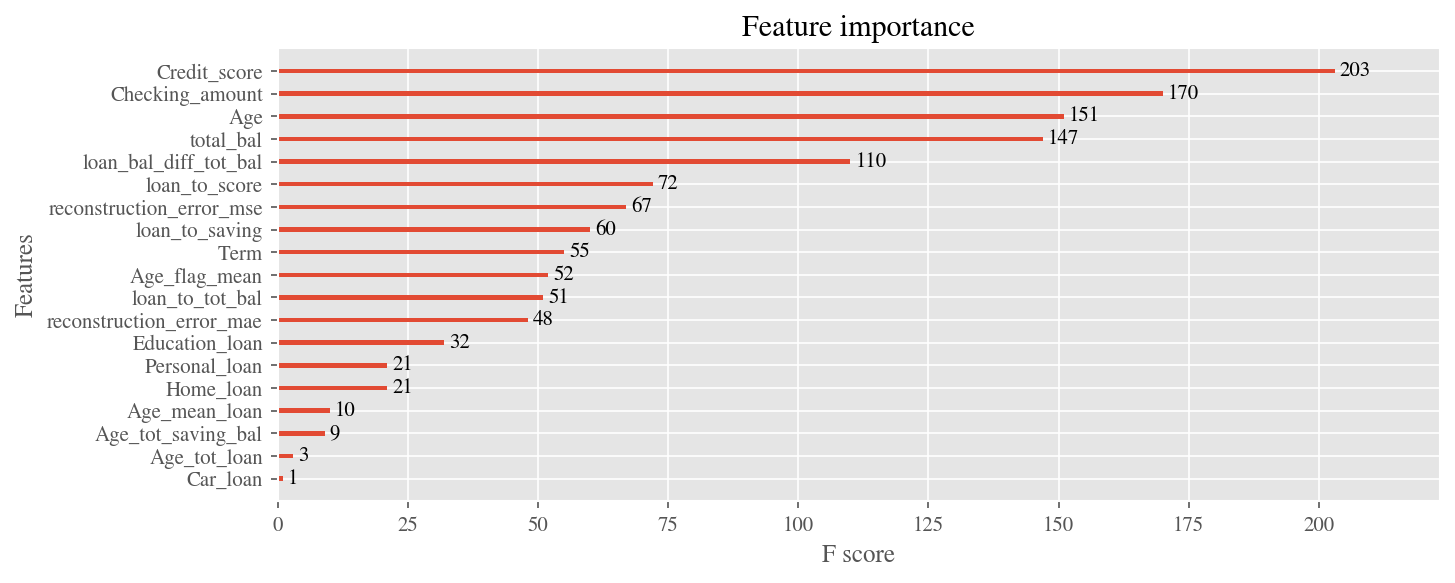

In [339]:
from xgboost import plot_importance
plot_importance(m, max_num_features=40)

In [340]:
categorical_features_indices = np.where(X.dtypes == 'object')[0]
categorical_features_indices

array([], dtype=int64)

In [341]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
# from catoost import catClassifier
from catboost import CatBoostClassifier

err_cat_ac = []
err_cat_f1 = []
err_cat_prec = []
err_cat_rec = []
err_cat_auc = []

y_pred_tot_cat = []
y_pred_tot_cat_prob = []


fold = KFold(n_splits=5, shuffle=True, random_state=42)
f = 0
for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier(
                         eval_metric='AUC', 
                         depth=6,
                         random_seed=42, 
                         iterations=1000, 
                         learning_rate=0.07,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1, 
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=50)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=50, cat_features=categorical_features_indices)
    y_pred = cat.predict(X_test)
    y_pred_prob = cat.predict_proba(X_test)[:,1]
    
    err_ac = accuracy_score(y_test, y_pred)
    err_f1 = f1_score(y_test, y_pred, average='weighted')
    err_prec = precision_score(y_test, y_pred, average='weighted')
    err_rec = recall_score(y_test, y_pred, average='weighted')
    err_auc = roc_auc_score(y_test, y_pred_prob)
    
    f += 1
    print("Fold:", f)
    print("Accuracy:", err_ac)
    print('F1 Score:', err_f1)
    print("Precision Score:", err_prec)
    print("Recall Score:", err_rec)
    print("AUC Score:", err_auc)
    print('\n')
    
    test_pred = cat.predict(Xtest)
    test_pred_proba = cat.predict_proba(Xtest)[:,1]
    
    err_cat_ac.append(err_ac)
    err_cat_f1.append(err_f1)
    err_cat_prec.append(err_prec)
    err_cat_rec.append(err_rec)
    err_cat_auc.append(err_auc)
    
    y_pred_tot_cat.append(test_pred)
    y_pred_tot_cat_prob.append(test_pred_proba)
    

Fold: 1
Accuracy: 0.9316770186335404
F1 Score: 0.931173254715631
Precision Score: 0.9314013352376522
Recall Score: 0.9316770186335404
AUC Score: 0.98355832467982


Fold: 2
Accuracy: 0.9503105590062112
F1 Score: 0.9503105590062112
Precision Score: 0.9503105590062112
Recall Score: 0.9503105590062112
AUC Score: 0.9791929382093316


Fold: 3
Accuracy: 0.937888198757764
F1 Score: 0.9382932757223872
Precision Score: 0.9390381596915508
Recall Score: 0.937888198757764
AUC Score: 0.9840996168582377


Fold: 4
Accuracy: 0.89375
F1 Score: 0.8904476141835692
Precision Score: 0.8942187500000001
Recall Score: 0.89375
AUC Score: 0.9669056811913955


Fold: 5
Accuracy: 0.95
F1 Score: 0.9502849788564074
Precision Score: 0.9509090909090909
Recall Score: 0.95
AUC Score: 0.9838169642857142




In [342]:
print(np.mean(err_cat_ac))
print(np.mean(err_cat_f1))
print(np.mean(err_cat_prec))
print(np.mean(err_cat_rec))
print(np.mean(err_cat_auc))

0.9327251552795032
0.932101936496841
0.933175578968901
0.9327251552795032
0.9795147050448998


In [343]:
result['cat1'] = np.mean(y_pred_tot_cat, 0).round().astype(int)
result['cat1'].value_counts()

0    146
1     57
Name: cat1, dtype: int64

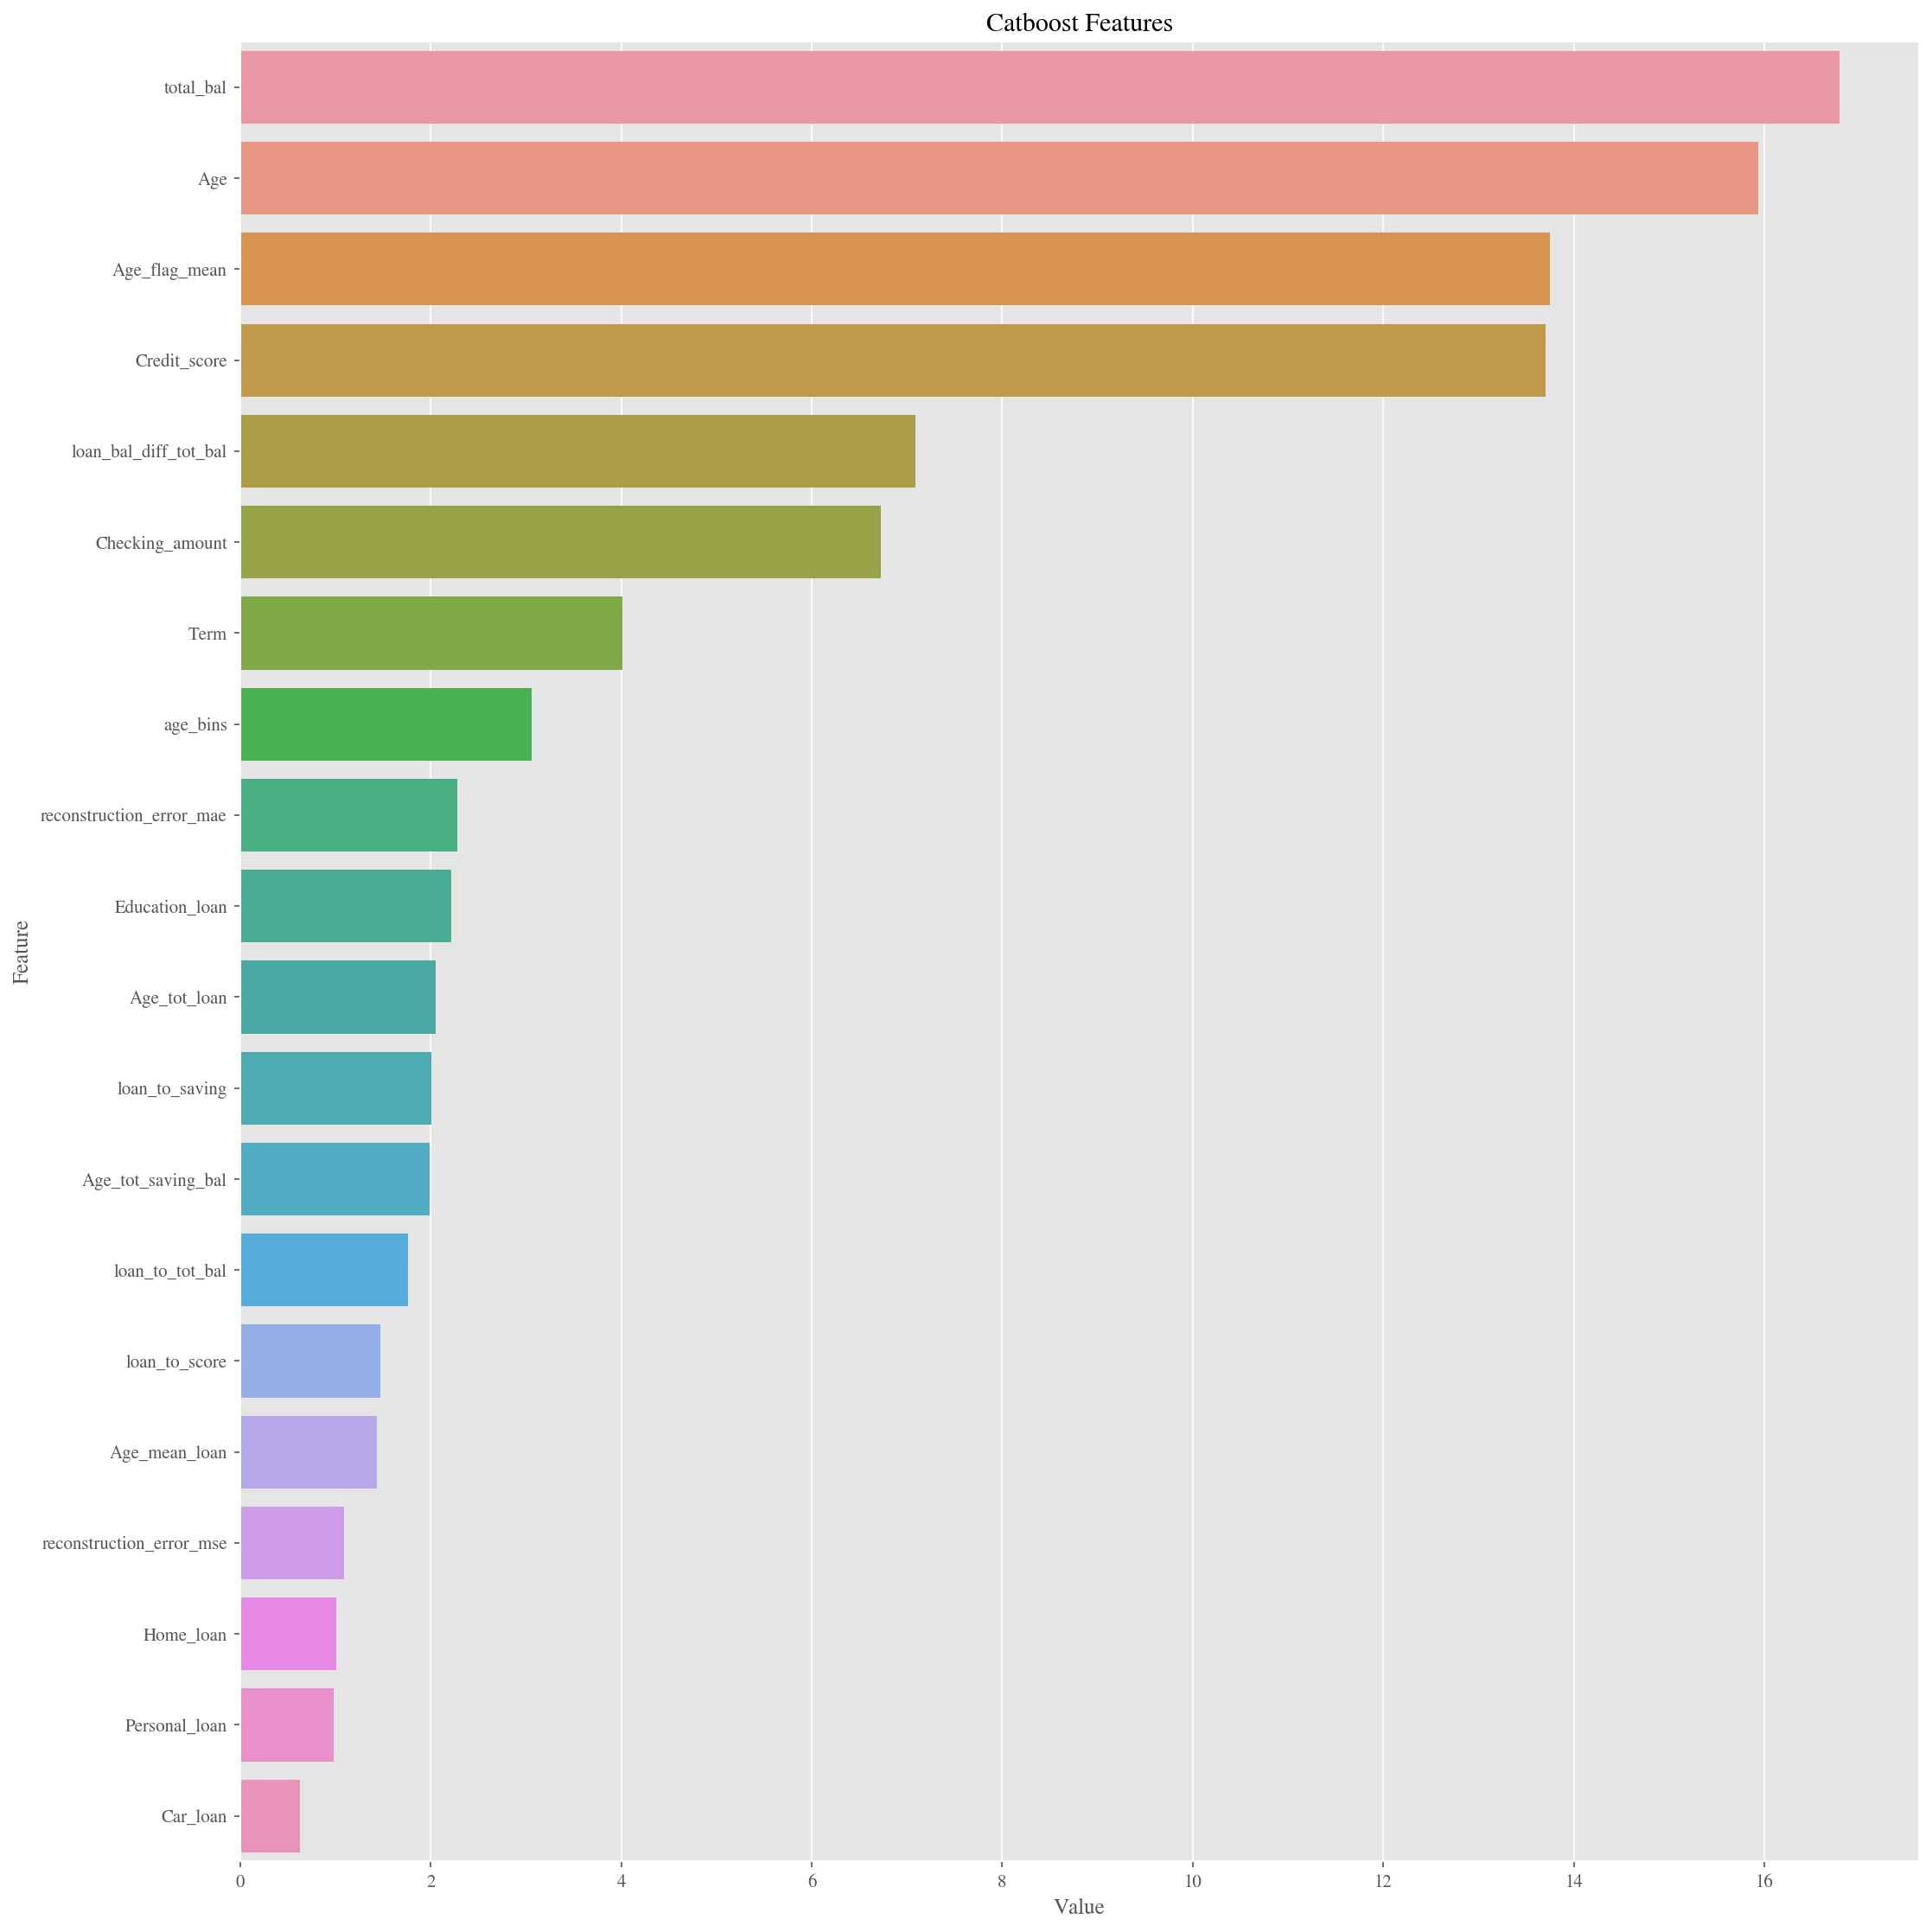

In [344]:
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

In [345]:
X = train_df[strong2]
Xtest = test_df[strong2]
X.shape, Xtest.shape

((803, 18), (203, 18))

In [346]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((602, 18), (602,), (201, 18), (201,))

In [386]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

err_lgb_ac = []
err_lgb_f1 = []
err_lgb_prec = []
err_lgb_rec = []
err_lgb_auc = []

y_pred_tot_lgb = []
y_pred_tot_lgb_prob = []


fold = KFold(n_splits=5, shuffle=True, random_state=42)
f = 0
for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    m=LGBMClassifier(n_estimators=1000,random_state=1994,learning_rate=0.03,colsample_bytree=0.2,objective='binary',
                     scale_pos_weight=1, bagging_fraction = 0.7265, feature_fraction = 0.5369, lambda_l2=0.05784,
                 min_data_in_leaf= 5, num_leaves=4)

    m.fit(X_train,y_train,eval_set=[(X_test, y_test)],eval_metric='auc', early_stopping_rounds=200,verbose=200)
    
    y_pred = m.predict(X_test)
    y_pred_prob = m.predict_proba(X_test)[:,1]
    
    test_pred = m.predict(Xtest)
    test_pred_proba = m.predict_proba(Xtest)[:,1]
    
    err_ac = accuracy_score(y_test, y_pred)
    err_f1 = f1_score(y_test, y_pred, average='weighted')
    err_prec = precision_score(y_test, y_pred, average='weighted')
    err_rec = recall_score(y_test, y_pred, average='weighted')
    err_auc = roc_auc_score(y_test, y_pred_prob)
    
    f += 1
    print("Fold:", f)
    print("Accuracy:", err_ac)
    print('F1 Score:', err_f1)
    print("Precision Score:", err_prec)
    print("Recall Score:", err_rec)
    print("AUC Score:", err_auc)
    print('\n')
    
    err_lgb_ac.append(err_ac)
    err_lgb_f1.append(err_f1)
    err_lgb_prec.append(err_prec)
    err_lgb_rec.append(err_rec)
    err_lgb_auc.append(err_auc)
    
    y_pred_tot_lgb.append(test_pred)
    y_pred_tot_lgb_prob.append(test_pred_proba)
    

Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.976982	valid_0's binary_logloss: 0.1697
Early stopping, best iteration is:
[78]	valid_0's auc: 0.982174	valid_0's binary_logloss: 0.211053
Fold: 1
Accuracy: 0.937888198757764
F1 Score: 0.937589793004067
Precision Score: 0.93761643223151
Recall Score: 0.937888198757764
AUC Score: 0.9821737625475943


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.973308	valid_0's binary_logloss: 0.186375
Early stopping, best iteration is:
[124]	valid_0's auc: 0.97541	valid_0's binary_logloss: 0.194831
Fold: 2
Accuracy: 0.906832298136646
F1 Score: 0.9072302640455273
Precision Score: 0.9077152096914944
Recall Score: 0.906832298136646
AUC Score: 0.9754098360655737


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.975096	valid_0's binary_logloss: 0.189821
Early stopping, best iteration is:
[103]	valid_0's auc: 0.976054	valid_0's binary_logloss: 0.210

In [387]:
print(np.mean(err_lgb_ac))
print(np.mean(err_lgb_f1))
print(np.mean(err_lgb_prec))
print(np.mean(err_lgb_rec))
print(np.mean(err_lgb_auc))

0.9190683229813665
0.9187562147653783
0.9192054053507759
0.9190683229813665
0.9769861694239182


In [388]:
result['lgb2'] = np.mean(y_pred_tot_lgb, 0).round().astype(int)
result['lgb2'].value_counts()

0    148
1     55
Name: lgb2, dtype: int64

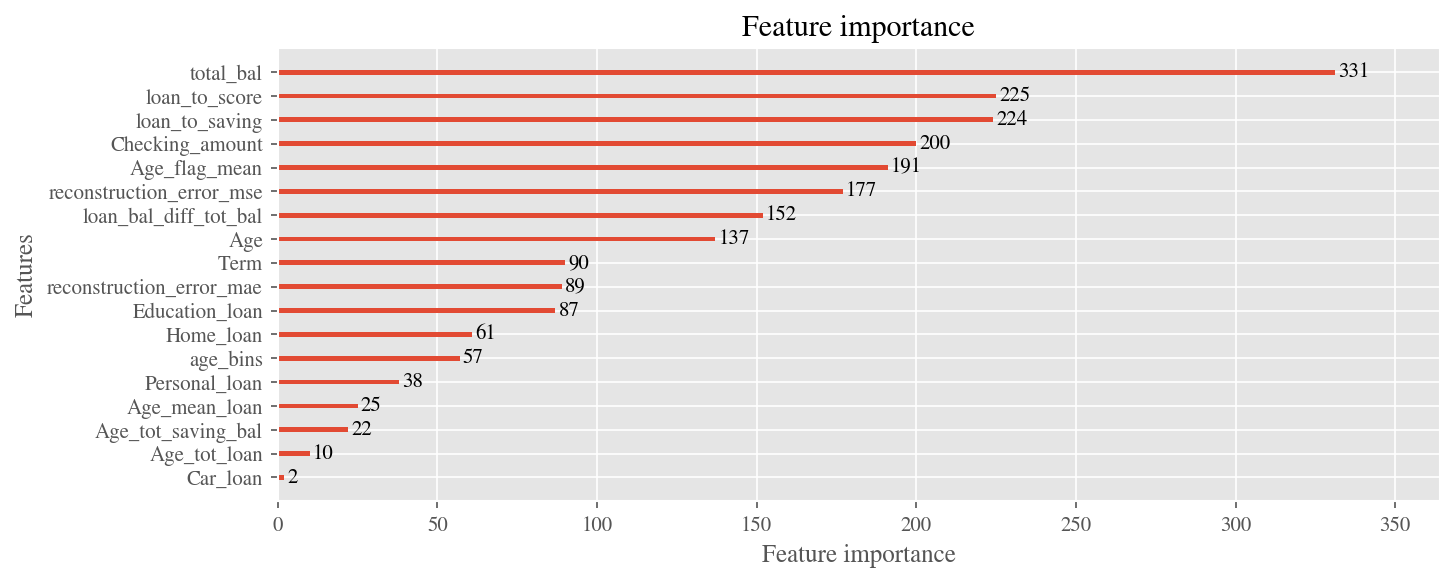

In [389]:
from lightgbm import plot_importance
plot_importance(m, max_num_features=40)
plt.savefig('lgbm_select2_plot.png')

In [352]:
from xgboost import XGBClassifier

err_xgb_ac = []
err_xgb_f1 = []
err_xgb_prec = []
err_xgb_rec = []
err_xgb_auc = []

y_pred_tot_xgb = []
y_pred_tot_xgb_prob = []


fold = KFold(n_splits=5, shuffle=True, random_state=42)
f = 0
for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    m=XGBClassifier(n_estimators=1000,random_state=1994,eval_metric='auc',learning_rate=0.1, bagging_fraction = 0.7265, 
                    feature_fraction = 0.5369, lambda_l2=0.05784,
                 min_data_in_leaf= 5, num_leaves=4)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200,verbose=200)
    
    y_pred = m.predict(X_test)
    y_pred_prob = m.predict_proba(X_test)[:,1]
    
    test_pred = m.predict(Xtest)
    test_pred_proba = m.predict_proba(Xtest)[:,1]
    
    err_ac = accuracy_score(y_test, y_pred)
    err_f1 = f1_score(y_test, y_pred, average='weighted')
    err_prec = precision_score(y_test, y_pred, average='weighted')
    err_rec = recall_score(y_test, y_pred, average='weighted')
    err_auc = roc_auc_score(y_test, y_pred_prob)
    
    f += 1
    print("Fold:", f)
    print("Accuracy:", err_ac)
    print('F1 Score:', err_f1)
    print("Precision Score:", err_prec)
    print("Recall Score:", err_rec)
    print("AUC Score:", err_auc)
    print('\n')
    
    err_xgb_ac.append(err_ac)
    err_xgb_f1.append(err_f1)
    err_xgb_prec.append(err_prec)
    err_xgb_rec.append(err_rec)
    err_xgb_auc.append(err_auc)
    
    y_pred_tot_xgb.append(test_pred)
    y_pred_tot_xgb_prob.append(test_pred_proba)
    

[0]	validation_0-auc:0.950971	validation_1-auc:0.959242
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:0.999892	validation_1-auc:0.979578
Stopping. Best iteration:
[30]	validation_0-auc:0.988926	validation_1-auc:0.981222

Fold: 1
Accuracy: 0.9440993788819876
F1 Score: 0.9439681624707564
Precision Score: 0.9439181652061062
Recall Score: 0.9440993788819876
AUC Score: 0.9812218760816891


[0]	validation_0-auc:0.957399	validation_1-auc:0.936213
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:1	validation_1-auc:0.972888
Stopping. Best iteration:
[146]	validation_0-auc:0.999931	validation_1-auc:0.97562

Fold: 2
Accuracy: 0.937888198757764
F1 Score: 0.9373234252120226
Precision Score: 0.9371463228405726
Recall Score: 0.93788819875

In [353]:
print(np.mean(err_xgb_ac))
print(np.mean(err_xgb_f1))
print(np.mean(err_xgb_prec))
print(np.mean(err_xgb_rec))
print(np.mean(err_xgb_auc))

0.9277562111801243
0.9274502247879702
0.927785938302544
0.9277562111801243
0.9758905938498904


In [354]:
result['xgb2'] = np.mean(y_pred_tot_xgb, 0).round().astype(int)
result['xgb2'].value_counts()

0    147
1     56
Name: xgb2, dtype: int64

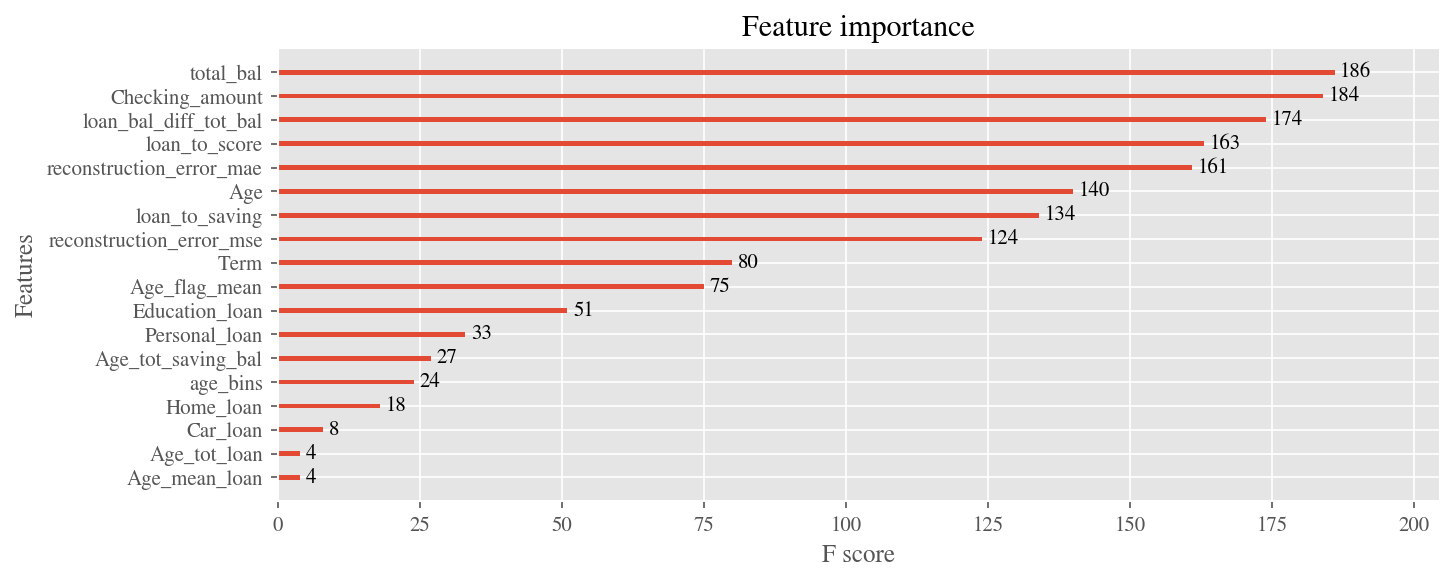

In [355]:
from xgboost import plot_importance
plot_importance(m, max_num_features=40)

In [356]:
categorical_features_indices = np.where(X.dtypes == 'object')[0]
categorical_features_indices

array([], dtype=int64)

In [357]:
X.shape

(803, 18)

In [358]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
# from catoost import catClassifier
from catboost import CatBoostClassifier

err_cat_ac = []
err_cat_f1 = []
err_cat_prec = []
err_cat_rec = []
err_cat_auc = []

y_pred_tot_cat = []
y_pred_tot_cat_prob = []


fold = KFold(n_splits=5, shuffle=True, random_state=42)
f = 0
for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier( 
                         eval_metric='AUC', 
                         depth=6,
                         random_seed=42, 
                         iterations=1000, 
                         learning_rate=0.07,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1, 
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=50)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=50, cat_features=categorical_features_indices)
    y_pred = cat.predict(X_test)
    y_pred_prob = cat.predict_proba(X_test)[:,1]
    
    err_ac = accuracy_score(y_test, y_pred)
    err_f1 = f1_score(y_test, y_pred, average='weighted')
    err_prec = precision_score(y_test, y_pred, average='weighted')
    err_rec = recall_score(y_test, y_pred, average='weighted')
    err_auc = roc_auc_score(y_test, y_pred_prob)
    
    f += 1
    print("Fold:", f)
    print("Accuracy:", err_ac)
    print('F1 Score:', err_f1)
    print("Precision Score:", err_prec)
    print("Recall Score:", err_rec)
    print("AUC Score:", err_auc)
    print('\n')
    
    test_pred = cat.predict(Xtest)
    test_pred_proba = cat.predict_proba(Xtest)[:,1]
    
    err_cat_ac.append(err_ac)
    err_cat_f1.append(err_f1)
    err_cat_prec.append(err_prec)
    err_cat_rec.append(err_rec)
    err_cat_auc.append(err_auc)
    
    y_pred_tot_cat.append(test_pred)
    y_pred_tot_cat_prob.append(test_pred_proba)
    

Fold: 1
Accuracy: 0.9254658385093167
F1 Score: 0.9247162888965841
Precision Score: 0.9252688713558278
Recall Score: 0.9254658385093167
AUC Score: 0.9873658705434406


Fold: 2
Accuracy: 0.9192546583850931
F1 Score: 0.9202473781221752
Precision Score: 0.922020982305966
Recall Score: 0.9192546583850931
AUC Score: 0.9785624211853721


Fold: 3
Accuracy: 0.9254658385093167
F1 Score: 0.9254658385093167
Precision Score: 0.9254658385093167
Recall Score: 0.9254658385093167
AUC Score: 0.9760536398467433


Fold: 4
Accuracy: 0.8875
F1 Score: 0.8844565217391306
Precision Score: 0.8868646238983399
Recall Score: 0.8875
AUC Score: 0.9536679536679536


Fold: 5
Accuracy: 0.94375
F1 Score: 0.9439138273773751
Precision Score: 0.9441625298768155
Recall Score: 0.94375
AUC Score: 0.9800967261904762




In [359]:
print(np.mean(err_cat_ac))
print(np.mean(err_cat_f1))
print(np.mean(err_cat_prec))
print(np.mean(err_cat_rec))
print(np.mean(err_cat_auc))

0.9202872670807452
0.9197599709289163
0.9207565691892532
0.9202872670807452
0.9751493222867971


In [360]:
result['cat2'] = np.mean(y_pred_tot_cat, 0).round().astype(int)
result['cat2'].value_counts()

0    147
1     56
Name: cat2, dtype: int64

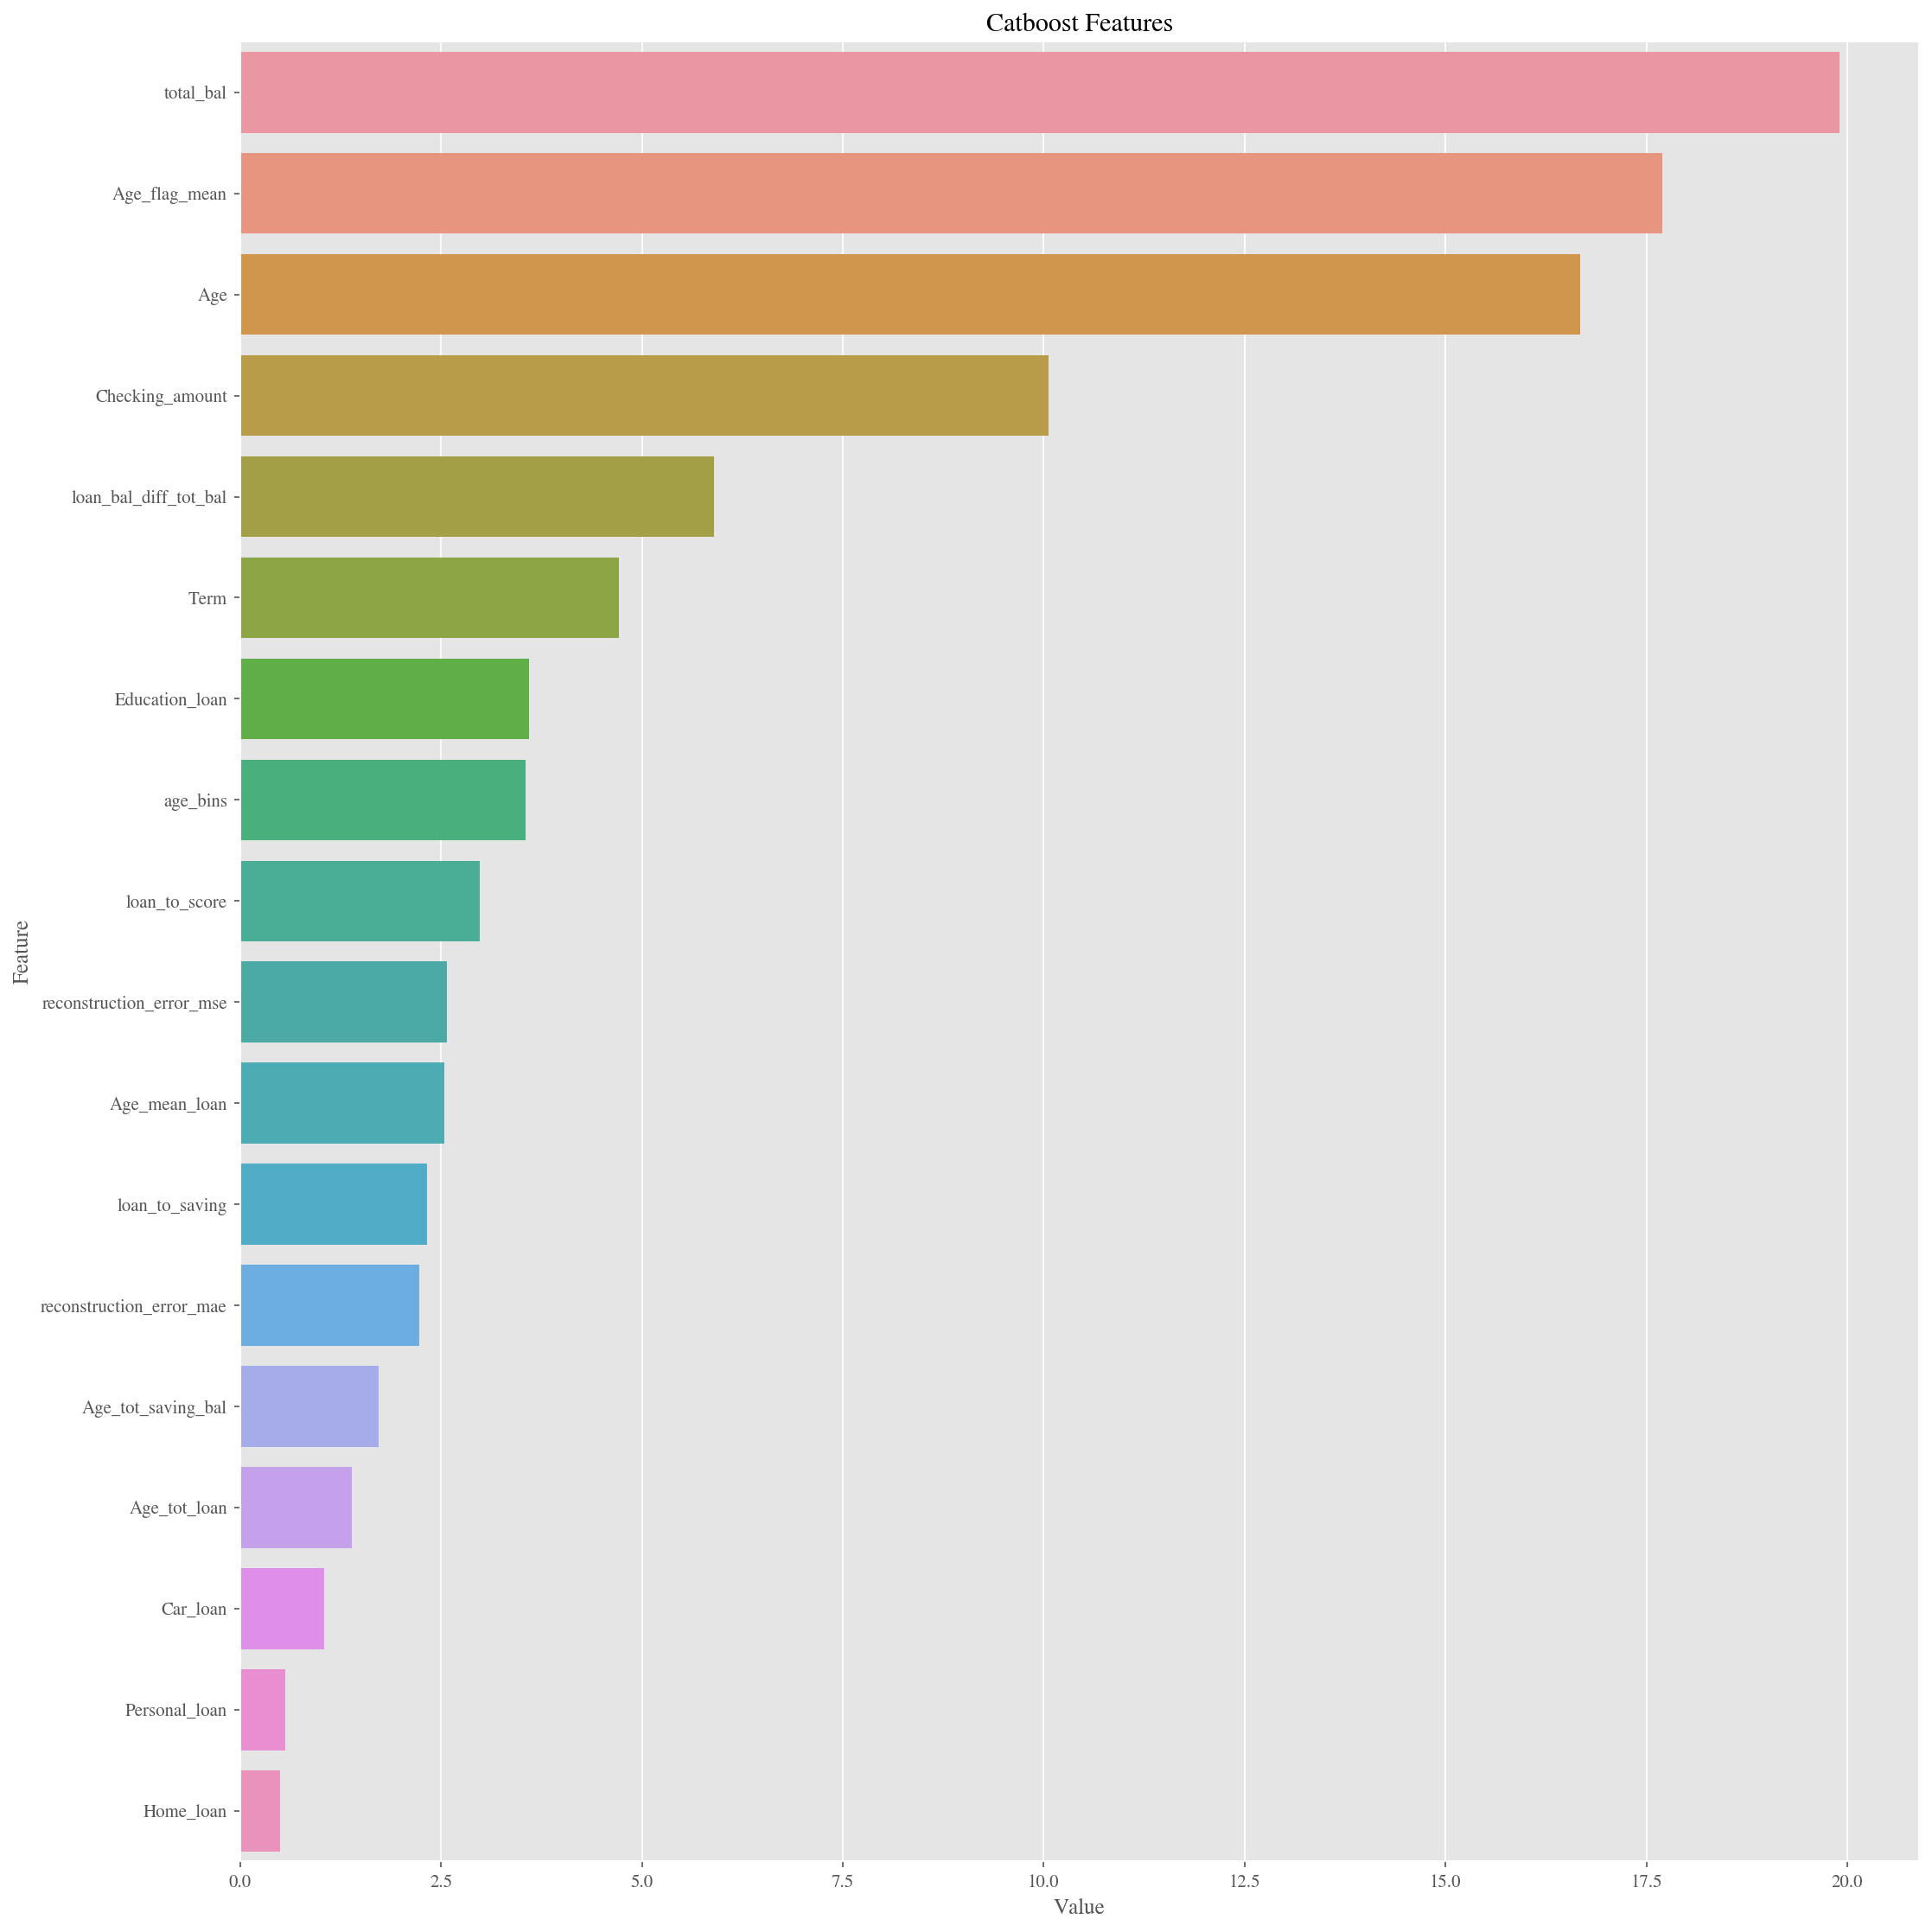

In [361]:
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

In [362]:
result.head()

,lgbm1,xgb1,cat1,lgb2,xgb2,cat2
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [384]:
final = pd.DataFrame()
final['ID'] = test['ID']
final['Default'] = result.mode(axis=1)[0].astype(int)
final['Default'].value_counts()

0    147
1     56
Name: Default, dtype: int64

In [385]:
final.to_csv("ShankarLal_IITMadras.csv", index=False)

In [108]:
from bayes_opt import BayesianOptimization

In [110]:
def lgb_evaluate(min_data_in_leaf,
                     bagging_fraction,
                     feature_fraction,
                     num_leaves,
                     lambda_l2,
                     ):

        params['min_data_in_leaf'] = int(min_data_in_leaf)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['num_leaves'] = int(num_leaves)
        params['lambda_l2'] = max(lambda_l2, 0),




        cv_result = lgb.cv(nfold=5,params=params, metrics='binary_logloss',stratified=False,train_set=lgbtrain,
               num_boost_round=num_rounds,seed=random_state, callbacks=[lgb.callback.early_stopping(50)])
        return -(cv_result.get('binary_logloss-mean')[-1])


def prepare_data():
        X = train_df1[strong2]
        _X = lgb.Dataset(X, label=y)

        return _X


lgbtrain = prepare_data()

num_rounds = 200
random_state = 0
num_iter = 1000
init_points = 5
params = {
        'eta': 0.1,
        'silent': 1,
        'eval_metric': 'binary_logloss',
        'verbose_eval': True,
        'seed': random_state
    }

lgbBO = BayesianOptimization(lgb_evaluate, {'min_data_in_leaf': (4, 100),
                                                'bagging_fraction': (0.5, 1),
                                                'feature_fraction': (0.5, 1),
                                                'num_leaves': (4, 100),
                                                'lambda_l2': (0, 5),
                                                })

lgbBO.maximize(init_points=init_points, n_iter=num_iter)


|   iter    |  target   | baggin... | featur... | lambda_l2 | min_da... | num_le... |
-------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds


C:\Users\shankar\Anaconda3\envs\tf\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Early stopping, best iteration is:
[30]	cv_agg's binary_logloss: 0.201507 + 0.0455535
|  1        | -0.2015   |  0.8285   |  0.5131   |  1.851    |  7.68     |  93.13    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	cv_agg's binary_logloss: 0.176336 + 0.0357676
|  2        | -0.1763   |  0.8943   |  0.6914   |  1.947    |  94.82    |  87.77    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	cv_agg's binary_logloss: 0.207092 + 0.0352305
|  3        | -0.2071   |  0.5693   |  0.5376   |  3.091    |  21.62    |  52.4     |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	cv_agg's binary_logloss: 0.174 + 0.0308178
|  4        | -0.174    |  0.8318   |  0.94     |  4.441    |  82.74    |  40.69    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	cv_agg's binary_logloss: 0.20

Early stopping, best iteration is:
[24]	cv_agg's binary_logloss: 0.21951 + 0.0509048
|  29       | -0.2195   |  0.5      |  0.5      |  0.0      |  4.0      |  75.31    |
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[160]	cv_agg's binary_logloss: 0.172388 + 0.0353721
|  30       | -0.1724   |  0.849    |  0.5068   |  0.1419   |  87.11    |  41.8     |
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[164]	cv_agg's binary_logloss: 0.177447 + 0.035435
|  31       | -0.1774   |  0.9732   |  0.5377   |  4.772    |  89.17    |  40.37    |
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[194]	cv_agg's binary_logloss: 0.173787 + 0.0334692
|  32       | -0.1738   |  0.5028   |  0.5325   |  0.5634   |  99.5     |  77.16    |
Training until validation scores don't improve for 50 rounds
Did not meet early stopping.

Early stopping, best iteration is:
[55]	cv_agg's binary_logloss: 0.182365 + 0.0337817
|  57       | -0.1824   |  0.5699   |  0.5726   |  0.1227   |  54.71    |  66.25    |
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[188]	cv_agg's binary_logloss: 0.174475 + 0.0324005
|  58       | -0.1745   |  0.9622   |  0.5308   |  4.858    |  39.6     |  4.392    |
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[181]	cv_agg's binary_logloss: 0.177829 + 0.0318945
|  59       | -0.1778   |  0.5766   |  0.5194   |  4.717    |  99.95    |  57.85    |
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[170]	cv_agg's binary_logloss: 0.173879 + 0.030656
|  60       | -0.1739   |  0.5754   |  0.5699   |  4.956    |  83.6     |  29.84    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iterat

Early stopping, best iteration is:
[25]	cv_agg's binary_logloss: 0.209539 + 0.0332968
|  85       | -0.2095   |  0.6629   |  0.5164   |  4.986    |  13.34    |  39.33    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	cv_agg's binary_logloss: 0.177196 + 0.031366
|  86       | -0.1772   |  0.8681   |  0.6255   |  4.924    |  65.31    |  4.227    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	cv_agg's binary_logloss: 0.179869 + 0.0362489
|  87       | -0.1799   |  0.9929   |  0.5224   |  0.02518  |  95.67    |  21.72    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	cv_agg's binary_logloss: 0.173326 + 0.0330474
|  88       | -0.1733   |  0.5347   |  0.51     |  0.04591  |  4.0      |  4.162    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	cv_agg's binary_logloss: 0.

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[164]	cv_agg's binary_logloss: 0.17349 + 0.0330868
|  114      | -0.1735   |  0.9888   |  0.548    |  4.157    |  83.41    |  35.59    |
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[180]	cv_agg's binary_logloss: 0.175111 + 0.0315646
|  115      | -0.1751   |  0.9885   |  0.5146   |  4.802    |  99.91    |  40.47    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	cv_agg's binary_logloss: 0.196948 + 0.0325751
|  116      | -0.1969   |  0.6191   |  0.9922   |  0.52     |  57.38    |  32.61    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	cv_agg's binary_logloss: 0.185679 + 0.0361948
|  117      | -0.1857   |  0.9623   |  0.579    |  4.943    |  61.44    |  42.04    |
Training until validation scores don't im

Early stopping, best iteration is:
[98]	cv_agg's binary_logloss: 0.183703 + 0.0394245
|  142      | -0.1837   |  0.5      |  0.5      |  0.0      |  46.32    |  21.65    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	cv_agg's binary_logloss: 0.186846 + 0.0322405
|  143      | -0.1868   |  0.8118   |  0.5132   |  0.03753  |  73.23    |  4.301    |
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[179]	cv_agg's binary_logloss: 0.174967 + 0.0337237
|  144      | -0.175    |  0.5519   |  0.5455   |  4.905    |  83.96    |  93.46    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	cv_agg's binary_logloss: 0.186116 + 0.0330105
|  145      | -0.1861   |  0.711    |  0.6496   |  4.998    |  73.52    |  99.73    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	cv_agg's binar

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[174]	cv_agg's binary_logloss: 0.174931 + 0.0309556
|  171      | -0.1749   |  0.9911   |  0.9163   |  2.551    |  99.77    |  63.27    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	cv_agg's binary_logloss: 0.185843 + 0.0396048
|  172      | -0.1858   |  0.9175   |  0.6331   |  0.09397  |  91.63    |  12.75    |
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[190]	cv_agg's binary_logloss: 0.174702 + 0.0361639
|  173      | -0.1747   |  0.5181   |  0.5143   |  1.727    |  86.77    |  90.67    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	cv_agg's binary_logloss: 0.205697 + 0.0413725
|  174      | -0.2057   |  0.5052   |  0.5422   |  4.911    |  11.02    |  50.6     |
Training until validation scores don't i

Early stopping, best iteration is:
[93]	cv_agg's binary_logloss: 0.182102 + 0.043475
|  199      | -0.1821   |  0.8915   |  0.5504   |  4.903    |  62.57    |  30.7     |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	cv_agg's binary_logloss: 0.200715 + 0.036609
|  200      | -0.2007   |  0.5      |  0.5      |  0.0      |  35.52    |  49.39    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	cv_agg's binary_logloss: 0.185108 + 0.0300528
|  201      | -0.1851   |  0.5102   |  0.5094   |  4.971    |  74.8     |  18.97    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	cv_agg's binary_logloss: 0.188996 + 0.0364818
|  202      | -0.189    |  0.5316   |  0.5134   |  0.1066   |  42.41    |  6.291    |
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[188]	cv_agg's binary_

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	cv_agg's binary_logloss: 0.17739 + 0.031826
|  228      | -0.1774   |  0.6832   |  0.5071   |  4.655    |  66.69    |  100.0    |
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[188]	cv_agg's binary_logloss: 0.174348 + 0.0326578
|  229      | -0.1743   |  0.5323   |  0.7208   |  4.793    |  88.51    |  4.017    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	cv_agg's binary_logloss: 0.175357 + 0.0320881
|  230      | -0.1754   |  0.5511   |  0.9519   |  0.03732  |  98.27    |  78.94    |
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[150]	cv_agg's binary_logloss: 0.172403 + 0.0317753
|  231      | -0.1724   |  0.8891   |  0.9746   |  0.1485   |  80.94    |  60.17    |
Training until validation scores don't improve for 50 

KeyboardInterrupt: 

In [111]:
folds = KFold(n_splits=5, shuffle=True, random_state=0)

In [170]:
# Xtrain = train_df[strong2]
# Xtest = test_df[strong2]

# params5 = {'bagging_fraction': 0.7265,
#  'feature_fraction': 0.5369,
#  'lambda_l2': 0.05784,
#  'min_data_in_leaf': 5,
#  'num_leaves': 4}

# model = LGBWrapper(params5)
# cvpred = get_oof_pred(model, Xtrain, y, KFold(n_splits=5, shuffle=True, random_state=0))
# model.fit(Xtrain, y)
# pred = model.predict(Xtrain)
# print('oof log_loss: {}'.format(log_loss(y, cvpred)))
# print('oof roc_auc: {}'.format(roc_auc_score(y, cvpred)))

# def minus_f_score(cutoff):
#     if (cutoff < 0) or (cutoff > 1):
#         return np.inf
#     else:
#         return - 1* f1_score(y, 1 * (cvpred > cutoff))   
    
# cutoff_null = [0]
# cut_f_min = fmin(minus_f_score, cutoff_null, disp=False)
# cut = cut_f_min[0]
# print('oof f1_score: {}'.format(f1_score(y, 1 * (cvpred > cut))))

# print('train log_loss: {}'.format(log_loss(y, pred)))
# print('train roc_auc: {}'.format(roc_auc_score(y, pred)))
# print('train f1_score: {}'.format(f1_score(y, 1 * (pred > cut))))

In [ ]:
def minus_f_score(m):
    cutoff, w1 = m
    cvpreds = w1*cvpred_lgb +  (1-w1)*cvpred_lgb2
    if (cutoff < 0) or (cutoff > 1):
        return np.inf
    elif (w1 < 0) or (w1 > 1):
        return np.inf
    else:
        return - 1* f1_score(y, 1 * (cvpreds > cutoff))

In [ ]:
cutoff_null = [0, 0.5]
cut_f_min = fmin(minus_f_score, cutoff_null)
cut, w = cut_f_min
print('cutoff: ', cut, w)

In [ ]:
print('f1_score: {}'.format(f1_score(y, 1 * (w*cvpred_lgb +  (1-w)*cvpred_lgb2 > cut))))
print('recall_score: {}'.format(recall_score(y, 1 * (w*cvpred_lgb +  (1-w)*cvpred_lgb2 > cut))))
print('precision_score: {}'.format(precision_score(y, 1 * (w*cvpred_lgb +  (1-w)*cvpred_lgb2 > cut))))